In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
base_dir = '/Users/achyuthkumarmiryala/Desktop/Files/Machine Learning Project/archive'

In [3]:
from glob import glob
# # Merge images from both folders into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

In [ ]:
# Load the CSV file (adjust the path to your CSV file)
df = pd.read_csv('/Users/achyuthkumarmiryala/Desktop/Files/Machine Learning Project/archive/HAM10000_metadata.csv')



In [5]:
df['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [6]:
df['localization'].value_counts()

back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64

In [8]:
df['dx_type'].value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [9]:
df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [10]:
lesion_type = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'}

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [12]:
df['cell_type_idx'] = pd.Categorical(df['dx']).codes
df

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

       cell_type_idx  
0                  2  
1                  2  
2                  2  
3                  2  
4                  2  
...              ...  
10010              0  
10011              0  
10012              0  
10013              0  
10014              4  

[10015 rows x 8 columns]

In [13]:
df['cell_type_idx'].value_counts()

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: cell_type_idx, dtype: int64

In [14]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
cell_type_idx     0
dtype: int64

In [15]:
df['age'].fillna((df['age'].mean()), inplace=True)

In [16]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
cell_type_idx    0
dtype: int64

<Axes: xlabel='sex', ylabel='count'>

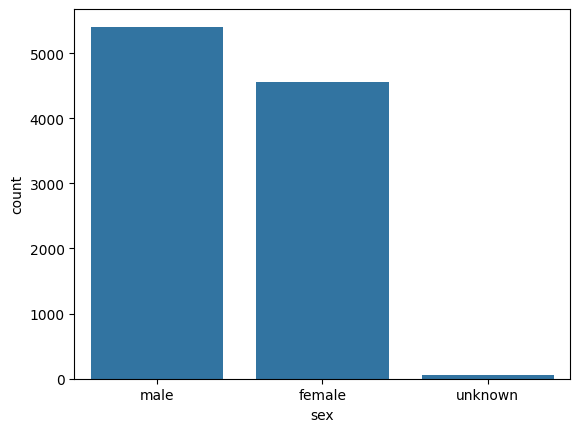

In [17]:
sns.countplot(x='sex',data=df)

In [20]:
df['cell_type'] = df['dx'].map(lesion_type.get)

In [21]:
df

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

       cell_type_idx                       cell_type  
0                  2  Benign keratosis-like lesions   
1                  2  Benign keratosis-like lesions   
2                  2  Benign keratosis-like lesions   
3                  2  Benign keratosis-like lesions   
4                  2  Benign keratosis-like lesions   
...              ...                             ...  
10010              0               Actinic keratoses  
10011              0               Actinic keratoses  
10012              0               Actinic keratoses  
10013              0               Actinic keratoses  
10014              4                        Melanoma  

[10015 rows x 9 columns]

/var/folders/sk/0cl07n8n2y70bmrj9y62bn2m0000gn/T/ipykernel_2367/4288453344.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'cividis')


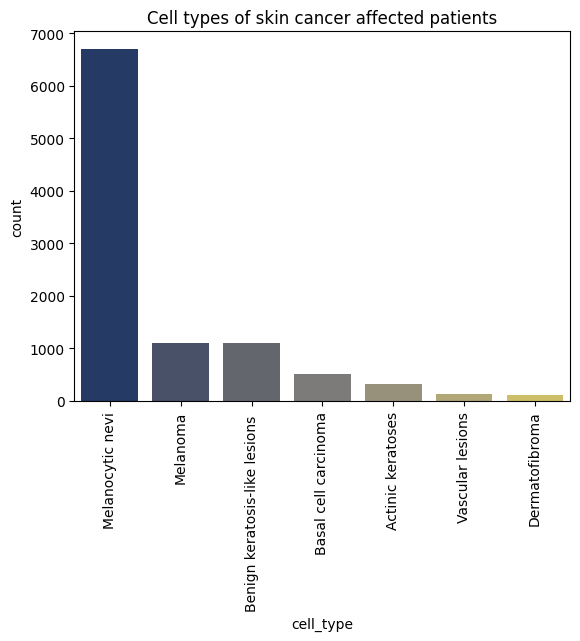

In [23]:
ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'cividis')
plt.title('Cell types of skin cancer affected patients')
plt.xticks(rotation=90)
plt.show()

<Axes: >

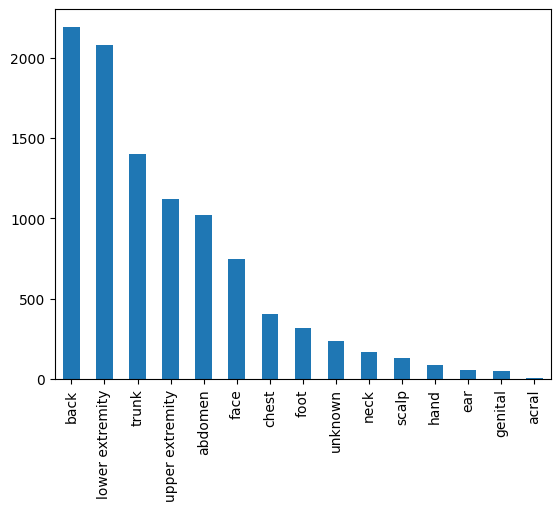

In [26]:
# plotting using Pandas library
df['localization'].value_counts().plot(kind='bar')

<Axes: >

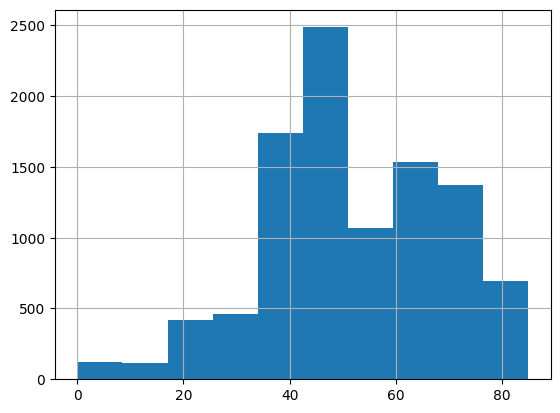

In [28]:
df['age'].hist()

In [31]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100))))

In [32]:
df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

   cell_type_idx                       cell_type  \
0              2  Benign keratosis-like lesions    
1              2  Benign keratosis-like lesions    
2              2  Benign keratosis-like lesions    
3              2  Benign keratosis-like lesions    
4              2  Benign keratosis-like lesions    

                                                path  \
0  /Users/liteshperumalla/Desktop/Files/Machine L...   
1  /Users/liteshperumalla/Desktop/Files/Machine L...   
2  /Users/liteshperumalla/Desktop/Files/Machine L...   
3  /Users/liteshperumalla/Desktop/Files/Machine L...   
4  /Users/liteshperumalla/Desktop/Files/Machine L...   

                                               image  
0  [[[190, 153, 195], [192, 155, 197], [191, 153,...  
1  [[[24, 13, 22], [24, 14, 24], [25, 14, 28], [3...  
2  [[[186, 128, 137], [190, 134, 148], [194, 137,...  
3  [[[24, 11, 17], [25, 12, 22], [36, 21, 30], [5...  
4  [[[132, 89, 112], [146, 101, 124], [158, 114, ...

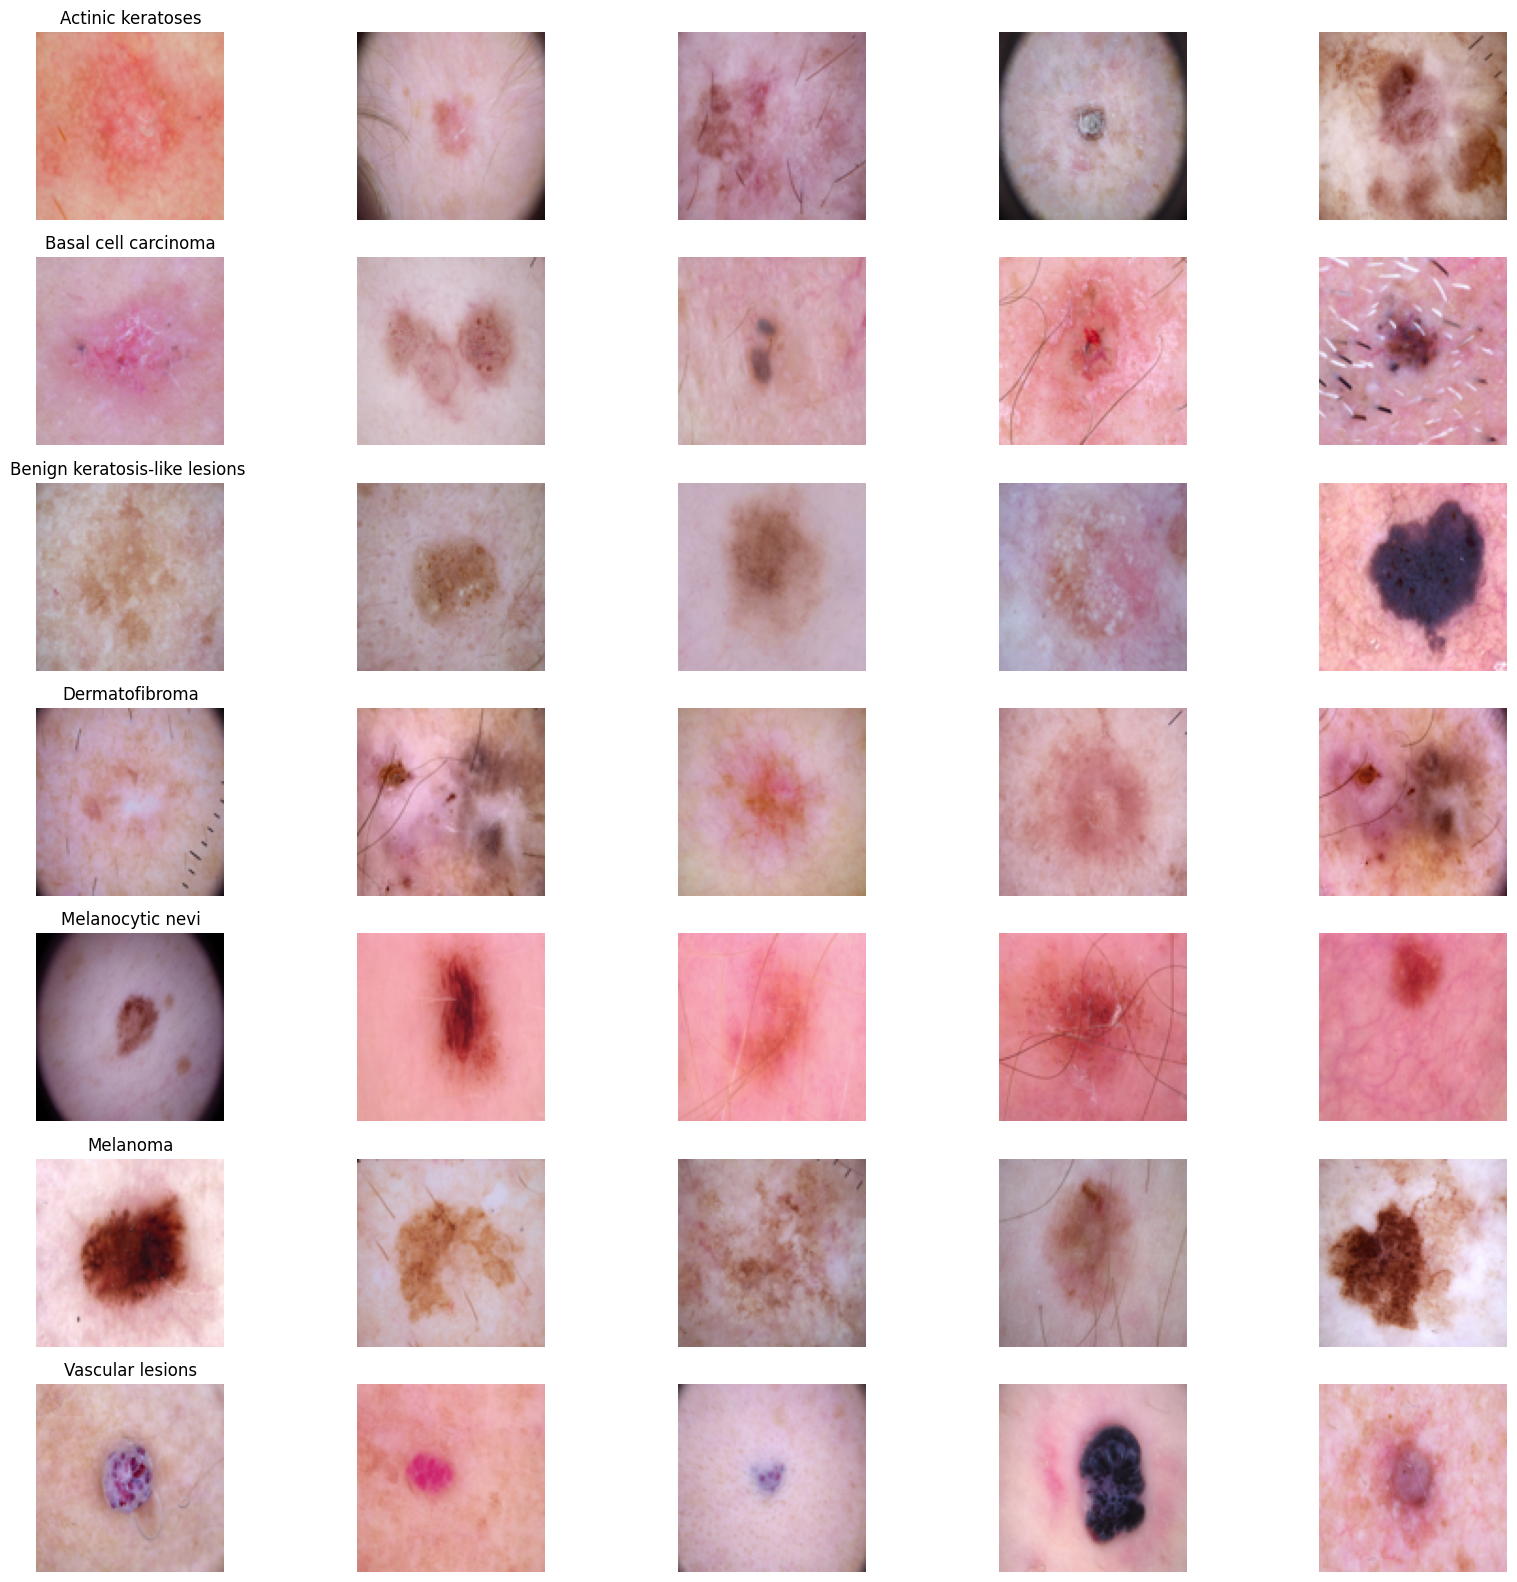

In [33]:
num_cat = 7   # no of categories
num_samp = 5  # no of samples to show from each category
r= 20         # random_state - change to get different images

fig, m_axs = plt.subplots(num_cat, num_samp, figsize = (20,20))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(num_samp, random_state=r).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [34]:
fig.savefig('category_samples.png', dpi=600)

In [35]:
y= df['cell_type_idx']
y

0        2
1        2
2        2
3        2
4        2
        ..
10010    0
10011    0
10012    0
10013    0
10014    4
Name: cell_type_idx, Length: 10015, dtype: int8

In [36]:
x= df.drop(columns=['cell_type_idx'],axis=1)

In [37]:
x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(x, y, test_size=0.20,random_state=10)

In [38]:
x_train_all['image'].iloc[0]

array([[[148,  93, 106],
        [149,  92, 105],
        [155, 105, 115],
        ...,
        [182, 118, 124],
        [181, 121, 126],
        [179, 124, 129]],

       [[147,  90, 107],
        [149,  93, 108],
        [155, 104, 115],
        ...,
        [183, 121, 126],
        [181, 121, 125],
        [179, 121, 126]],

       [[149,  94, 112],
        [152,  97, 117],
        [151, 101, 113],
        ...,
        [185, 125, 129],
        [181, 122, 126],
        [179, 119, 124]],

       ...,

       [[146,  91,  97],
        [146,  93,  99],
        [142,  89,  99],
        ...,
        [180, 131, 133],
        [180, 132, 133],
        [176, 129, 129]],

       [[145,  92,  97],
        [142,  89,  96],
        [141,  89,  99],
        ...,
        [178, 129, 132],
        [179, 130, 133],
        [177, 130, 131]],

       [[144,  88,  95],
        [138,  84,  90],
        [140,  84,  92],
        ...,
        [176, 128, 131],
        [176, 126, 129],
        [175, 128, 129]]

In [39]:
x_train_all['image'].iloc[0].shape

(100, 100, 3)

In [40]:
x_train = np.asarray(x_train_all['image'].tolist())
x_test = np.asarray(x_test_all['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [41]:
y_train = tf.keras.utils.to_categorical(y_train_all, num_classes = 7)
y_test = tf.keras.utils.to_categorical(y_test_all, num_classes = 7)

In [42]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [43]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 20)

In [44]:
x_train = x_train.reshape(x_train.shape[0], *(100, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 100, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5215058110417696..1.6408277990710785].


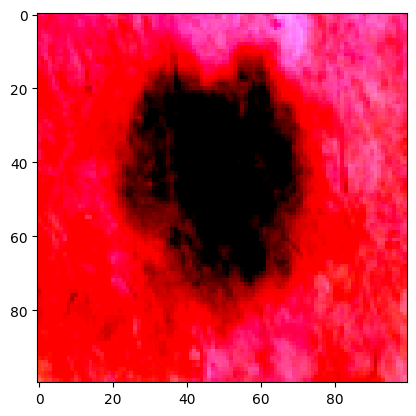

In [45]:
image_array = x_train[10]
plt.imshow(image_array)

In [46]:
print(np.sum(np.isnan(x_train)))
print(np.sum(np.isnan(y_train)))
print(np.sum(np.isnan(x_test)))
print(np.sum(np.isnan(y_test)))
print(np.sum(np.isnan(x_validate)))
print(np.sum(np.isnan(y_validate)))

0
0
0
0
0
0


In [47]:
model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (11, 11), padding= 'same', activation="relu",input_shape=(100, 100, 3)),
    tf.keras.layers.Conv2D(64, (7,7), padding= 'same', activation="relu"),

    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3,3), padding= 'same',  activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (3,3), padding= 'same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (3,3), padding= 'same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(512, (3,3), padding= 'valid', activation="relu"),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(600, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation="softmax")
]
)

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 600)            │     7,680,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 600)            │         2,400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         4,207 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,496,807 (36.23 MB)

 Trainable params: 9,495,223 (36.22 MB)

 Non-trainable params: 1,584 (6.19 KB)

In [49]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [111]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy', # for one-hot encoded y
              metrics=['accuracy'])

In [112]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_data= (x_validate,y_validate),
                    batch_size=64,
                    callbacks=early_stop)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 769s 7s/step - accuracy: 0.5281 - loss: 1.5589 - val_accuracy: 0.6808 - val_loss: 1.9842
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 767s 7s/step - accuracy: 0.6852 - loss: 0.8788 - val_accuracy: 0.6671 - val_loss: 1.0086
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 768s 7s/step - accuracy: 0.7119 - loss: 0.8139 - val_accuracy: 0.5786 - val_loss: 0.9989
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 760s 7s/step - accuracy: 0.6982 - loss: 0.7939 - val_accuracy: 0.6633 - val_loss: 1.0199
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 764s 7s/step - accuracy: 0.7345 - loss: 0.7218 - val_accuracy: 0.7444 - val_loss: 0.7870
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 762s 7s/step - accuracy: 0.7405 - loss: 0.6987 - val_accuracy: 0.7506 - val_loss: 0.8174
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 767s 7s/step - accuracy: 0.7490 - loss: 0.6836 - val_accuracy: 0.7170 - val_loss: 0.7643
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 771s 7s/step - accuracy: 0.7567 - loss: 0.6495 - val_accu

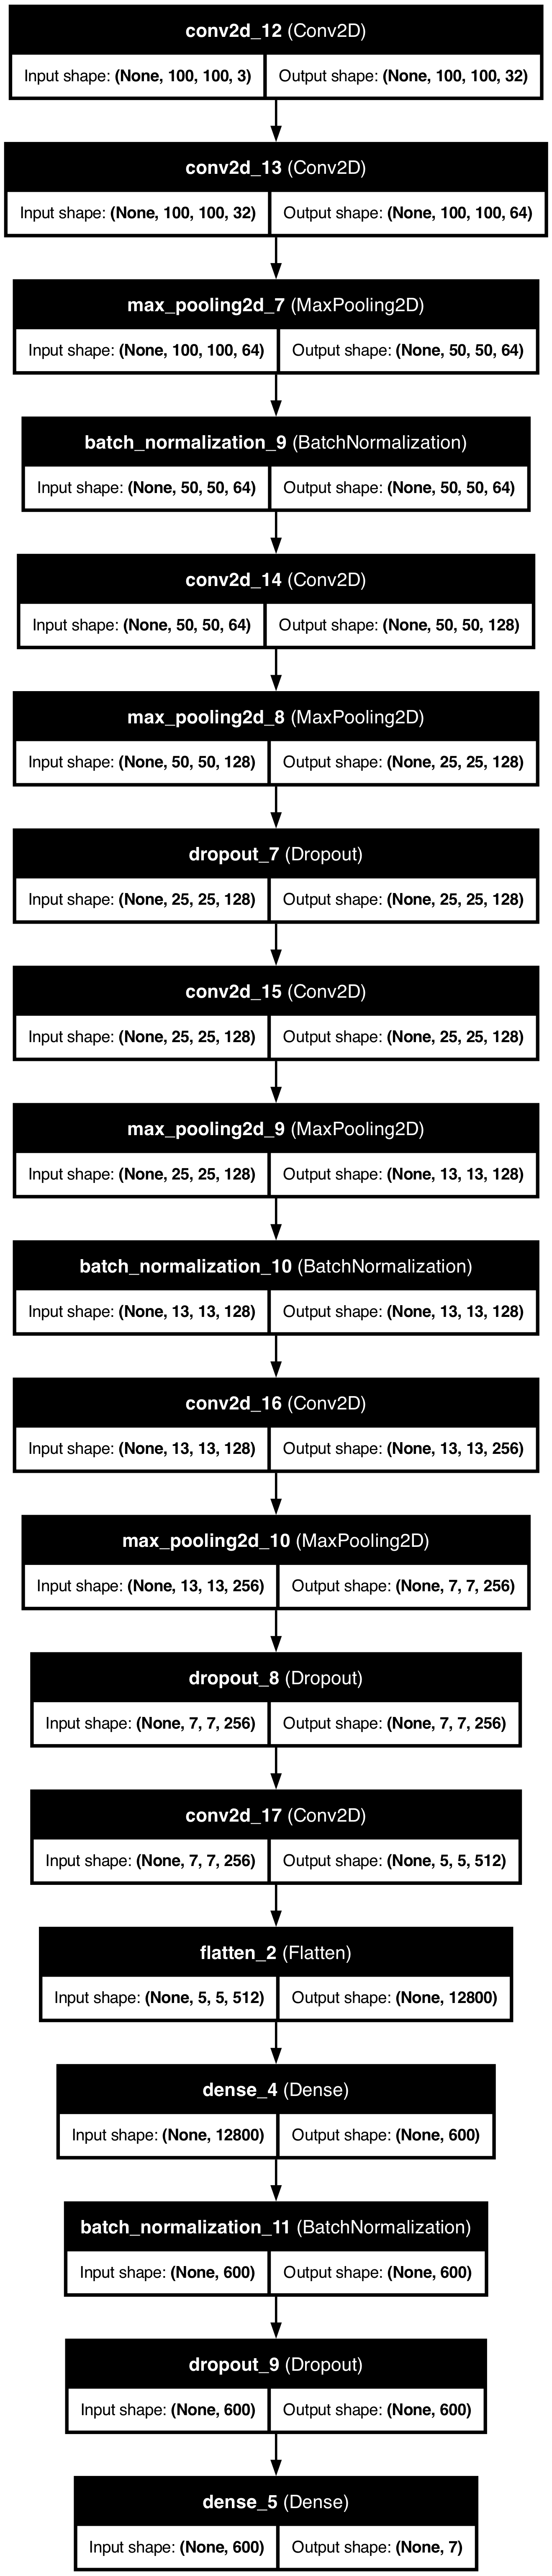

In [116]:
from tensorflow.keras.utils import plot_model

# Now you can use plot_model
plot_model(model, to_file='/Users/liteshperumalla/Desktop/Files/Machine Learning Project/model_plot.png', show_shapes=True, show_layer_names=True)


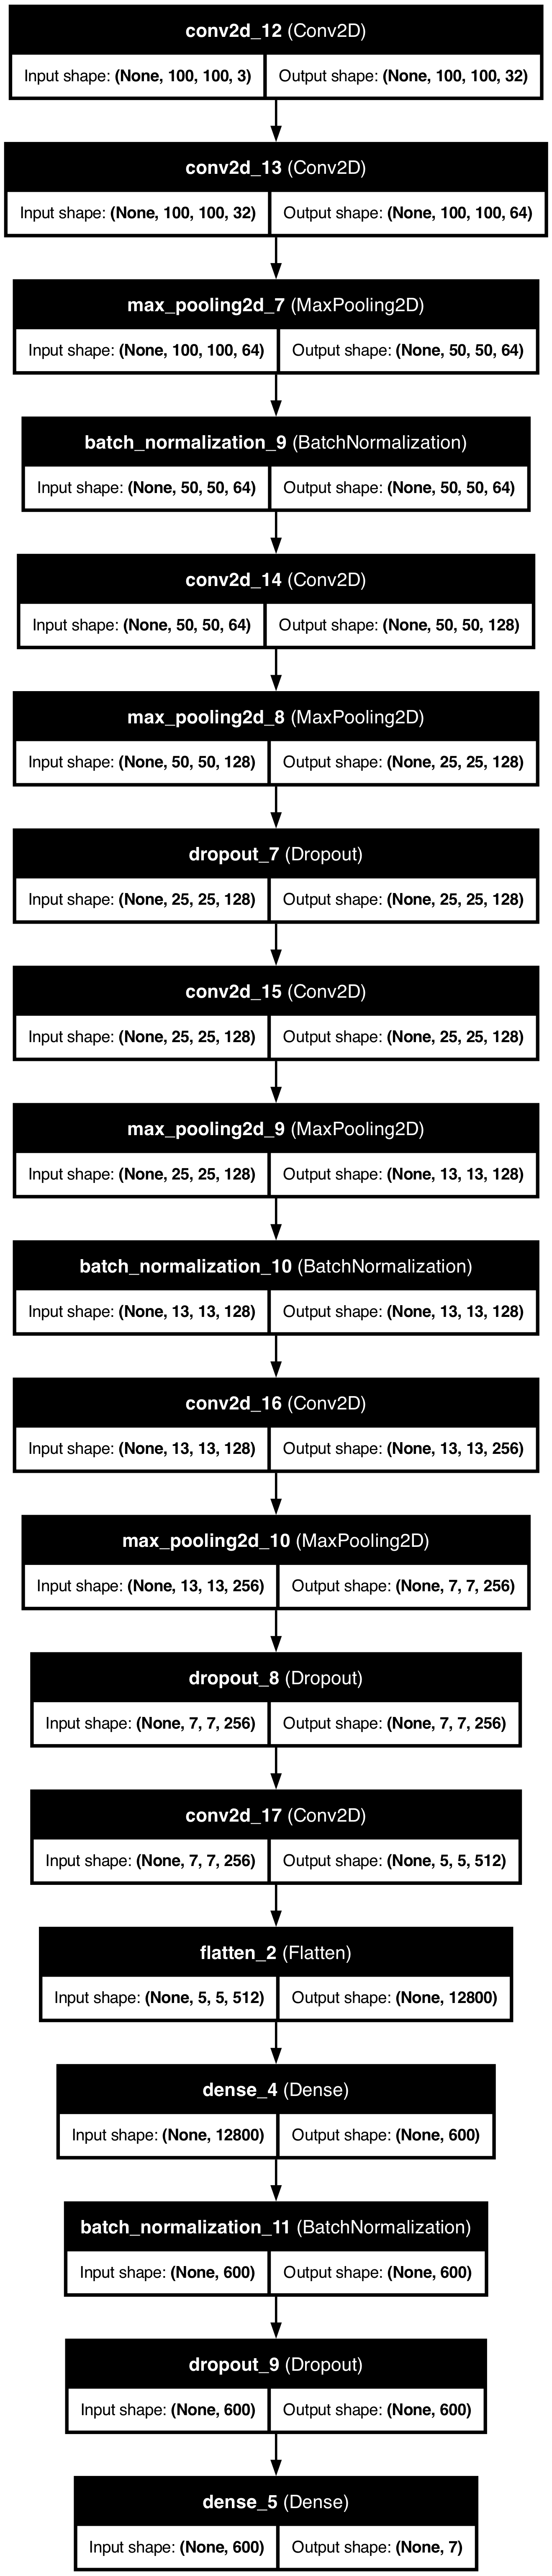

In [117]:
plot_model(model, to_file='/Users/liteshperumalla/Desktop/Files/Machine Learning Project/model_plot.png', show_shapes=True, show_layer_names=True)

In [118]:
fig.savefig('model_arch.png', dpi=600)

In [119]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 929ms/step - accuracy: 0.7296 - loss: 0.7352
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 934ms/step - accuracy: 0.7145 - loss: 0.8092
Validation: accuracy = 0.703242  ;  loss_v = 0.799484
Test: accuracy = 0.724413  ;  loss = 0.757506


In [120]:
df = pd.DataFrame(history.history)
df.head()

accuracy      loss  val_accuracy  val_loss
0  0.617476  1.188132      0.680798  1.984218
1  0.688766  0.865566      0.667082  1.008610
2  0.706241  0.816465      0.578554  0.998868
3  0.709709  0.784677      0.663342  1.019934
4  0.722885  0.744610      0.744389  0.786968

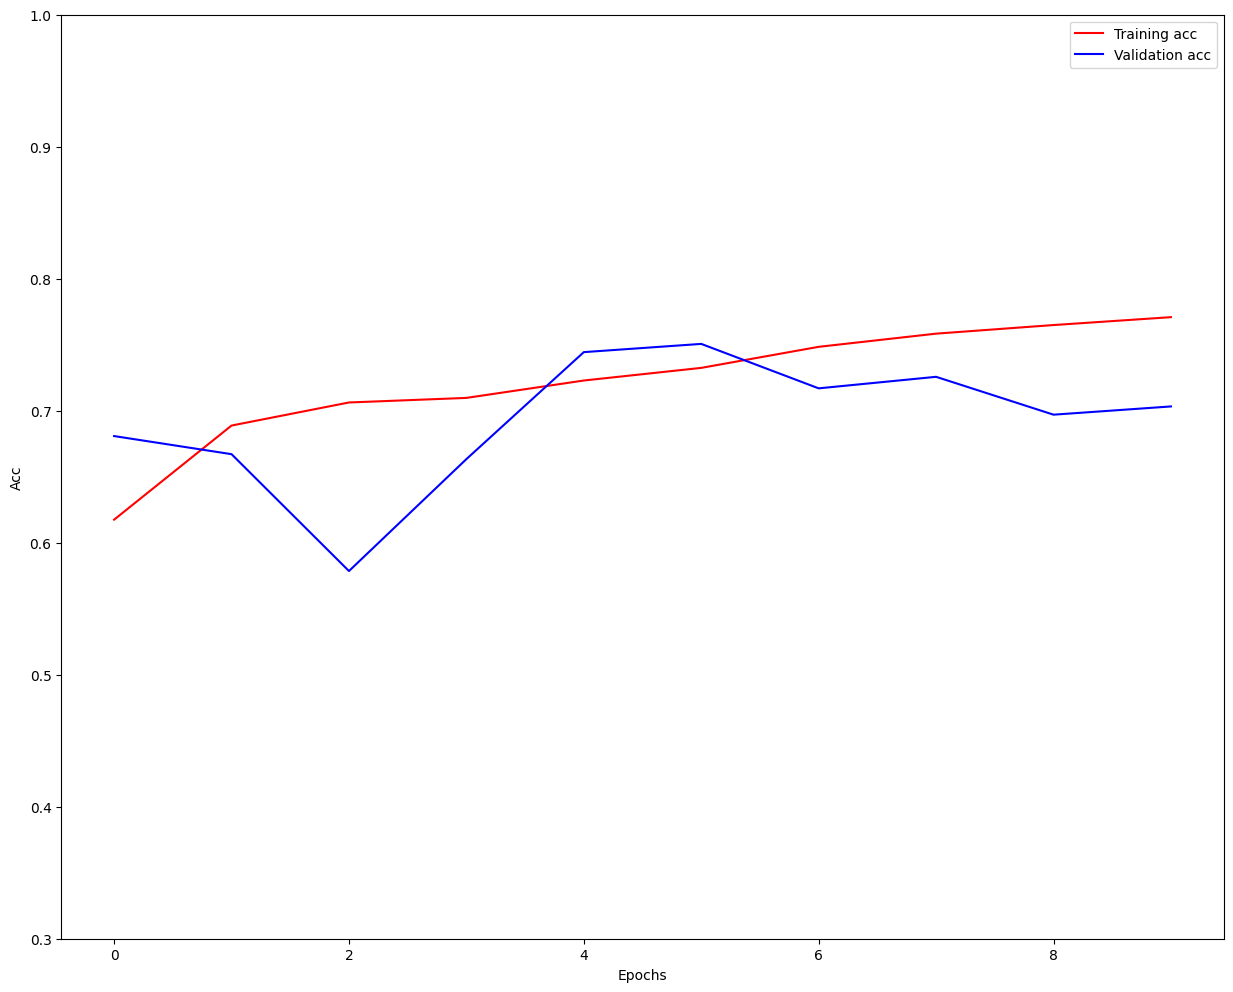

In [121]:
train_acc = df["accuracy"]
val_acc = df["val_accuracy"]
epochs = range(len(train_acc))

plt.figure(figsize=(15,12))
plt.ylim([0.3, 1])
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 820ms/step


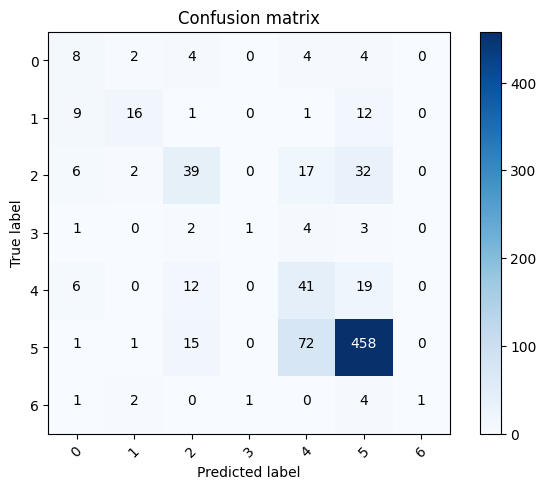

In [ ]:
import itertools
 def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 930ms/step


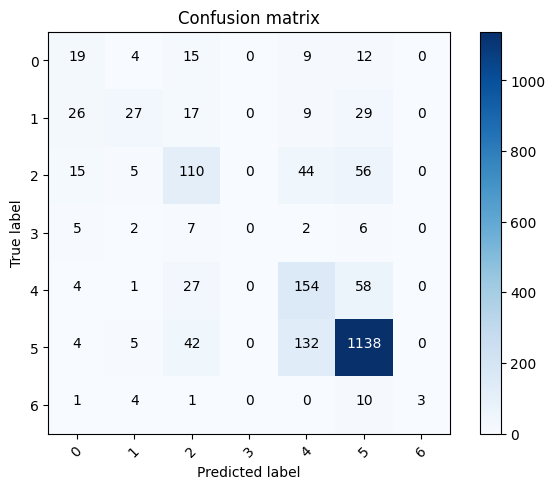

In [124]:
# Predict the values from the test dataset
Y_pred = model.predict(x_test) 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

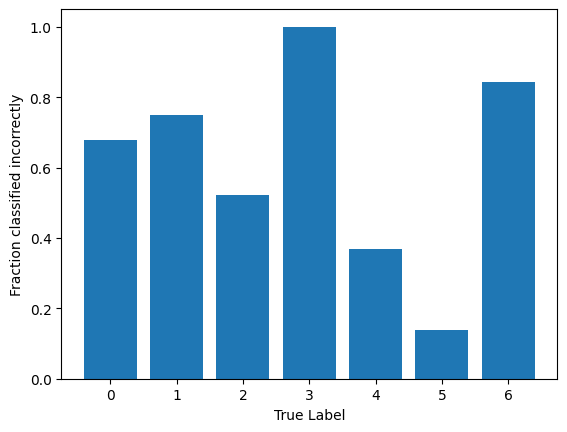

In [125]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [112]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

In [117]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers, layers

model1 = Sequential()

# Create Model1 Structure
model1.add(layers.Input(shape=[100, 100, 3]))
model1.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model1.add(layers.MaxPooling2D())
model1.add(layers.BatchNormalization())

model1.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model1.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model1.add(layers.MaxPooling2D())
model1.add(layers.BatchNormalization())

model1.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model1.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model1.add(layers.MaxPooling2D())
model1.add(layers.BatchNormalization())

model1.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model1.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model1.add(layers.MaxPooling2D())

model1.add(layers.Flatten())
model1.add(layers.Dropout(rate=0.2))
model1.add(layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model1.add(layers.BatchNormalization())

model1.add(layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
model1.add(layers.BatchNormalization())

model1.add(layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
model1.add(layers.BatchNormalization())

model1.add(layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.L1L2()))
model1.add(layers.BatchNormalization())

model1.add(layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))

# Compile the model
model1.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_137 (Conv2D)             │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_138 (Conv2D)             │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_139 (Conv2D)             │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_140 (Conv2D)             │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_141 (Conv2D)             │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_142 (Conv2D)             │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_143 (Conv2D)             │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 3,568,839 (13.61 MB)

 Trainable params: 3,567,431 (13.61 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [118]:
print(x_validate
       .shape)

(802, 100, 100, 3)


In [119]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

In [120]:
history = model1.fit(x_train ,
                    y_train ,
                    epochs=10 ,
                    batch_size=128,
                    validation_data=(x_test , y_test) ,
                    callbacks=[learning_rate_reduction])

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.4692 - loss: 1.8351 - val_accuracy: 0.1922 - val_loss: 3.4792 - learning_rate: 0.0010
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.6927 - loss: 1.1798 - val_accuracy: 0.6555 - val_loss: 1.2833 - learning_rate: 0.0010
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 229s 4s/step - accuracy: 0.7356 - loss: 0.9741 - val_accuracy: 0.6740 - val_loss: 1.1154 - learning_rate: 0.0010
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.7660 - loss: 0.8156 - val_accuracy: 0.7059 - val_loss: 0.9960 - learning_rate: 0.0010
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.8044 - loss: 0.6955 - val_accuracy: 0.7154 - val_loss: 0.9463 - learning_rate: 0.0010
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.8240 - loss: 0.5842 - val_accuracy: 0.7274 - val_loss: 0.8763 - learning_rate: 0.0010
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.8589 - loss: 0.4689 - val_acc

In [122]:
train_score = model1.evaluate(x_train, y_train, verbose= 1)
test_score = model1.evaluate(x_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 241ms/step - accuracy: 0.8946 - loss: 0.3332
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 251ms/step - accuracy: 0.7389 - loss: 0.8554
Train Loss:  0.3393639028072357
Train Accuracy:  0.8907073736190796
--------------------
Test Loss:  0.909182608127594
Test Accuracy:  0.7368946671485901


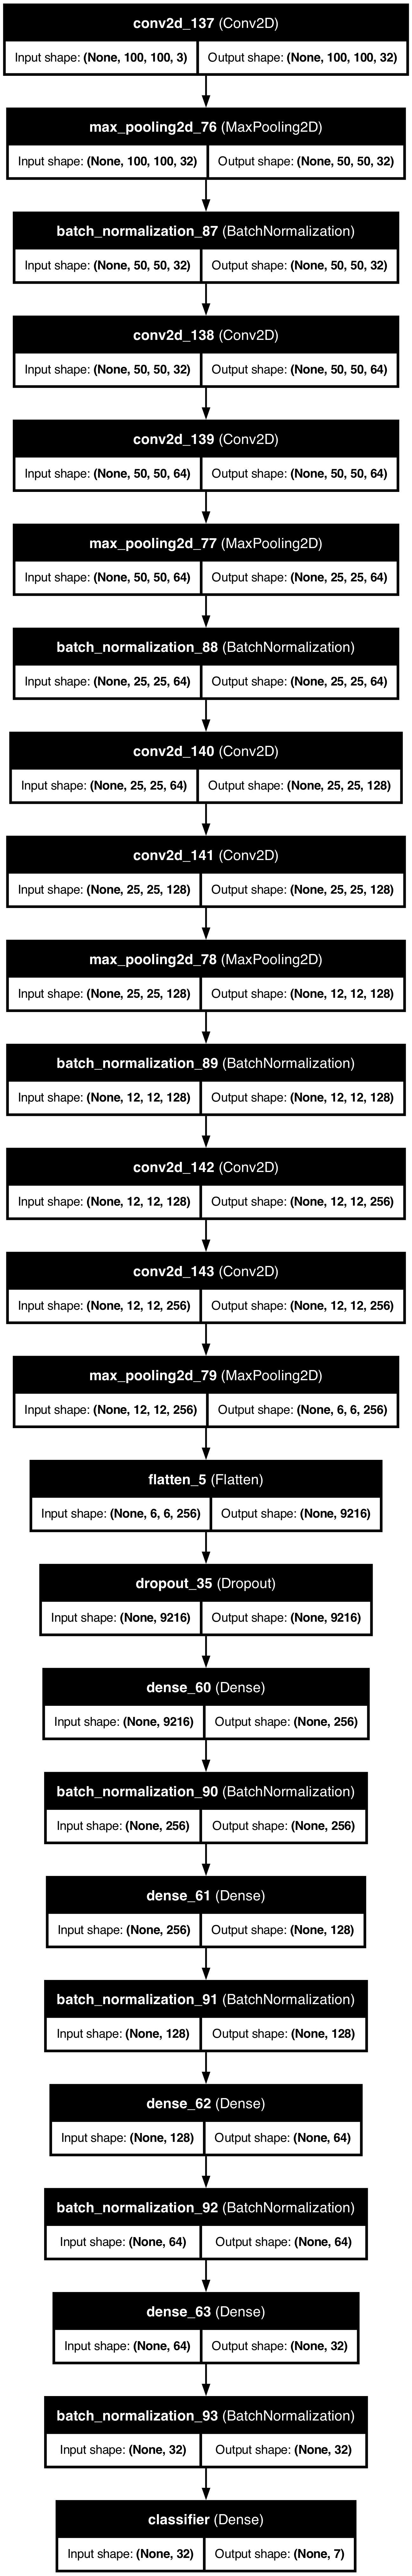

In [123]:
from tensorflow.keras.utils import plot_model

# Now you can use plot_model
plot_model(model1, to_file='/Users/liteshperumalla/Desktop/Files/Machine Learning Project/model1_plot.png', show_shapes=True, show_layer_names=True)

In [125]:
df1 = pd.DataFrame(history.history)
df1.head()

accuracy      loss  val_accuracy  val_loss  learning_rate
0  0.556865  1.589758      0.192212  3.479214          0.001
1  0.705687  1.123028      0.655517  1.283273          0.001
2  0.738835  0.952670      0.673989  1.115413          0.001
3  0.768932  0.799621      0.705941  0.995951          0.001
4  0.793620  0.702986      0.715427  0.946315          0.001

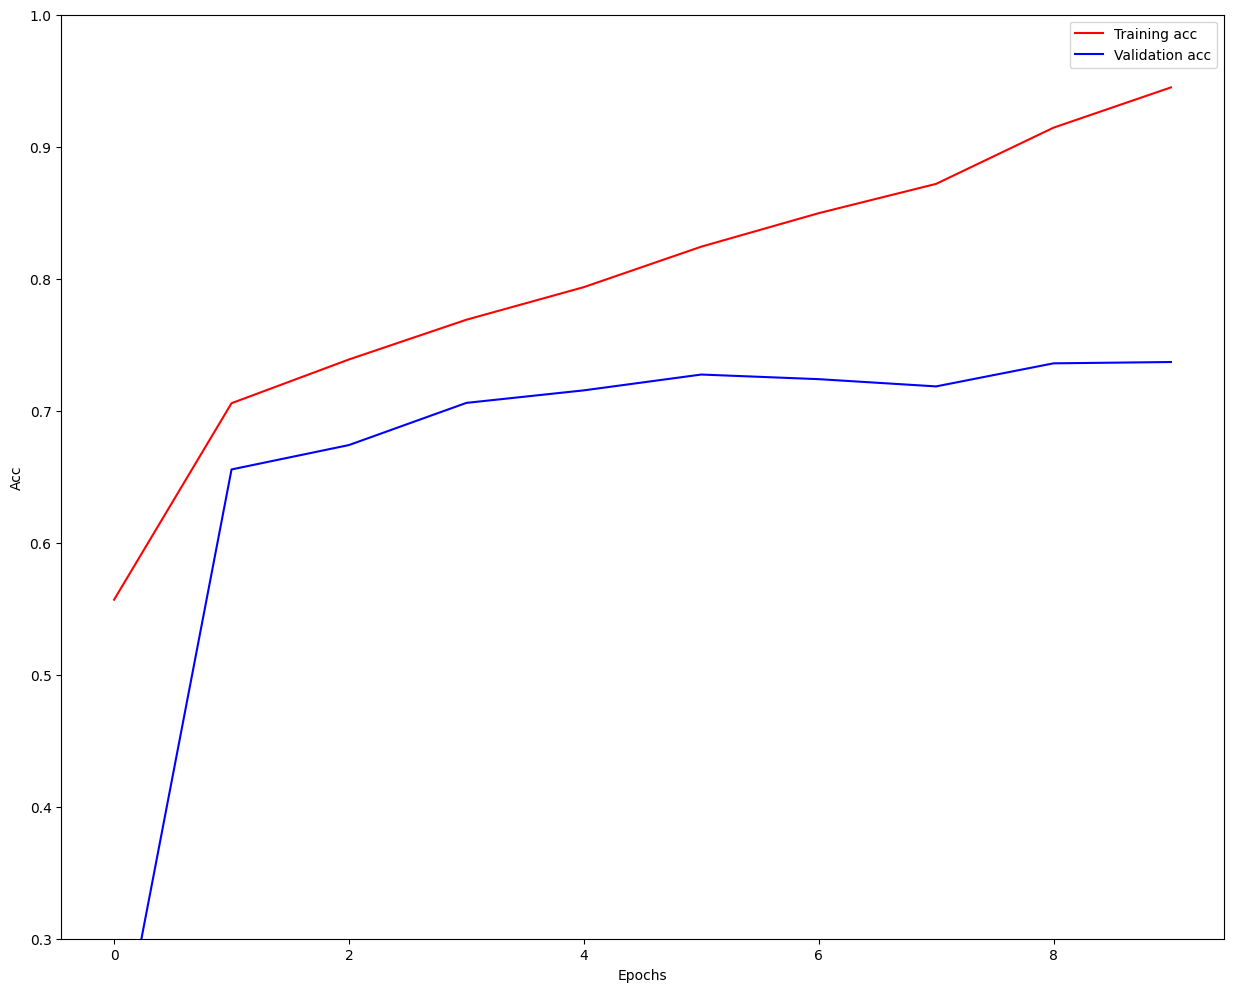

In [126]:
train_acc = df1["accuracy"]
val_acc = df1["val_accuracy"]
epochs = range(len(train_acc))

plt.figure(figsize=(15,12))
plt.ylim([0.3, 1])
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

In [127]:
y_true = np.array(y_test)
y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step


In [ ]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step


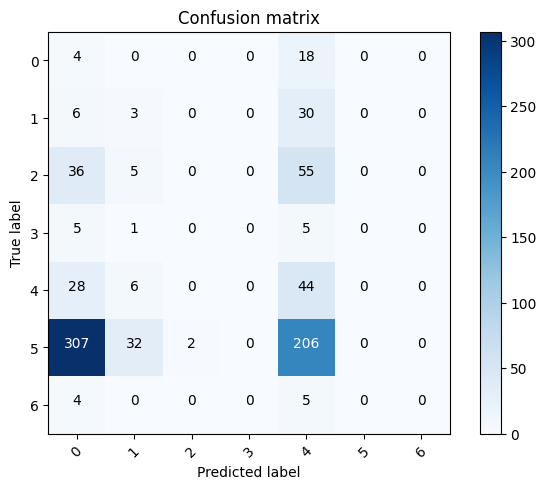

In [129]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 860ms/step


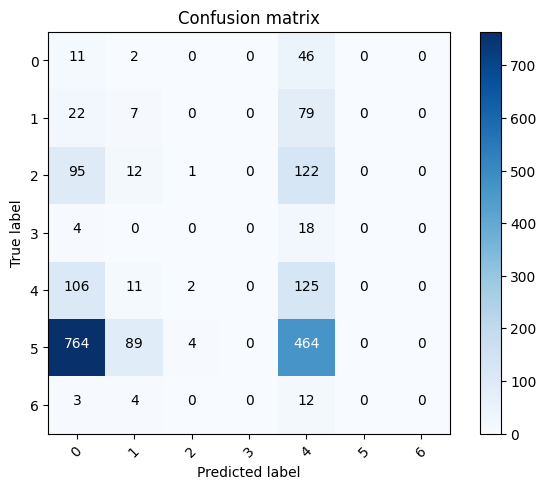

In [130]:
# Predict the values from the test dataset
Y_pred = model.predict(x_test) 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

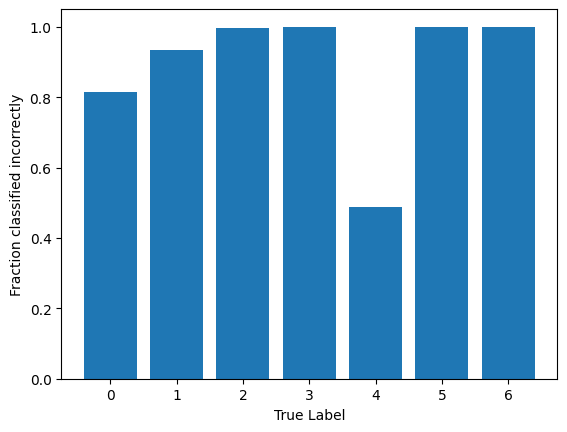

In [131]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


x_train = x_train.reshape(x_train.shape[0], -1)
x_validate = x_validate.reshape(x_validate.shape[0], -1)
# Scale the data
scaler = StandardScaler()

# Apply PCA (increase components if possible)
pca = PCA(n_components=50)

# Initialize logistic regression with adjusted parameters
log_reg = LogisticRegression(
    max_iter=2000,
    solver='saga',
    multi_class='multinomial',
    class_weight='balanced'
)

# Create pipeline with scaler, PCA, and logistic regression
model3 = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('logreg', log_reg)
])

# Train the model
model3.fit(x_train, y_train)

# Predictions and evaluation
y_train_pred = model3.predict(x_train)
y_validate_pred = model3.predict(x_validate)

print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation Accuracy:", accuracy_score(y_validate, y_validate_pred))
print("\nClassification Report (Validation):\n", classification_report(y_validate, y_validate_pred))
print("\nConfusion Matrix (Validation):\n", confusion_matrix(y_validate, y_validate_pred))


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training Accuracy: 0.5457697642163661
Validation Accuracy: 0.5211970074812967

Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.04      0.09      0.06        22
           1       0.32      0.38      0.35        39
           2       0.36      0.50      0.42        96
           3       0.07      0.36      0.12        11
           4       0.22      0.40      0.29        78
           5       0.91      0.57      0.70       547
           6       0.14      0.56      0.23         9

    accuracy                           0.52       802
   macro avg       0.30      0.41      0.31       802
weighted avg       0.71      0.52      0.58       802


Confusion Matrix (Validation):
 [[  2   6   5   6   2   0   1]
 [  9  15   3   5   1   1   5]
 [  5   5  48   4  19  11   4]
 [  0   1   1   4   2   2   1]
 [  5   2  11   9  31  16   4]
 [ 28  16  64  29  82 313  15]
 [  0   2   0   0   1   1   5]]


In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Set up the pipeline with Random Forest
model_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('rf', RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42))
])

# Grid search for best hyperparameters
param_grid = {
    'rf__n_estimators': [200],
    'rf__max_depth': [20],
    'rf__min_samples_split': [10],
    'rf__min_samples_leaf': [5],
    'rf__max_features': ['sqrt']
}

grid_search = GridSearchCV(model_rf, param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(x_train, y_train)

# Evaluate on validation set
train_accuracy = grid_search.score(x_train, y_train)
validate_accuracy = grid_search.score(x_validate, y_validate)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", validate_accuracy)
print("Best Params:", grid_search.best_params_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=5, rf__min_samples_split=10, rf__n_estimators=200; total time=  38.3s
[CV] END rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=5, rf__min_samples_split=10, rf__n_estimators=200; total time=  30.7s
[CV] END rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=5, rf__min_samples_split=10, rf__n_estimators=200; total time=  43.9s
Training Accuracy: 0.9889042995839112
Validation Accuracy: 0.7194513715710723
Best Params: {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}


In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base models
base_models = [
    ('rf', RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=5, min_samples_split=5, n_estimators=200)),
    ('xgb', XGBClassifier(max_depth=10, n_estimators=150))
]

# Define the Stacking Classifier
stacked_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Train the stacked model
stacked_model.fit(x_train, y_train)

# Evaluate on validation data
train_accuracy = stacked_model.score(x_train, y_train)
val_accuracy = stacked_model.score(x_validate, y_validate)
print("Stacked Model Training Accuracy:", train_accuracy)
print("Stacked Model Validation Accuracy:", val_accuracy)


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np

# Convert one-hot encoded labels to single-label format if necessary
if y_train.ndim > 1:
    y_train = np.argmax(y_train, axis=1)
if y_validate.ndim > 1:
    y_validate = np.argmax(y_validate, axis=1)

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train.reshape(x_train.shape[0], -1), y_train)

# Standardize features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_balanced)
x_validate_scaled = scaler.transform(x_validate.reshape(x_validate.shape[0], -1))

# Apply PCA to reduce dimensions (adjust n_components based on explained variance)
pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train_scaled)
x_validate_pca = pca.transform(x_validate_scaled)

# Train Logistic Regression model with softmax (multinomial)
log_reg = LogisticRegression(max_iter=2000, C=0.5, multi_class='multinomial', solver='lbfgs')
log_reg.fit(x_train_pca, y_train_balanced)

# Evaluate
y_train_pred = log_reg.predict(x_train_pca)
y_validate_pred = log_reg.predict(x_validate_pca)

print("Training Accuracy:", accuracy_score(y_train_balanced, y_train_pred))
print("Validation Accuracy:", accuracy_score(y_validate, y_validate_pred))
print("\nClassification Report (Validation):")
print(classification_report(y_validate, y_validate_pred))
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_validate, y_validate_pred))


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Accuracy: 0.6427833072447503
Validation Accuracy: 0.5037406483790524

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.12      0.27      0.16        22
           1       0.29      0.33      0.31        39
           2       0.38      0.48      0.42        96
           3       0.03      0.18      0.05        11
           4       0.21      0.40      0.27        78
           5       0.91      0.55      0.68       547
           6       0.16      0.67      0.26         9

    accuracy                           0.50       802
   macro avg       0.30      0.41      0.31       802
weighted avg       0.70      0.50      0.57       802


Confusion Matrix (Validation):
[[  6   4   4   3   2   0   3]
 [  7  13   2   6   1   2   8]
 [  6   3  46   5  20  10   6]
 [  1   1   1   2   2   3   1]
 [  6   1  11  13  31  15   1]
 [ 25  22  57  36  94 300  13]
 [  0   1   0   0   1   1   6]]
